In [10]:
# 셀 1: 필요한 라이브러리 불러오기
import matplotlib.pyplot as plt
from matplotlib import rc

# 윈도우 예시 (맑은 고딕)
rc('font', family='NanumGothic')

# 또는 맥 예시
# rc('font', family='AppleGothic')

# 또는 리눅스 예시
# rc('font', family='NanumGothic')

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


# 실험 개요: 다중 질량-스프링 감쇠 시스템의 동기 및 비동기 진동 특성 분석

## 1. 실험 목적
본 실험은 여러 개의 질량체(갈레)가 스프링과 감쇠기로 연결된 시스템에서  
- **동기 조건**(모든 갈레의 물리적 특성이 동일할 때)과  
- **비동기 조건**(질량, 스프링 상수, 감쇠 계수에 약간의 차이가 있을 때)  

각각의 진동 거동과 가속도, 에너지 변화를 비교 분석하는 것을 목적으로 한다.  
특히, 상호작용 스프링을 통해 갈레 간 힘이 어떻게 전달되는지와, 중력 영향 하에서 시스템의 안정성과 동작 변화를 관찰한다.

---

## 2. 이론적 배경

### 2.1 질량-스프링-감쇠 시스템 모델
각 갈레는 질량 \( m_i \), 스프링 상수 \( k_i \), 감쇠 계수 \( c_i \)를 가지며, 위치를 \( x_i(t) \), 속도를 \( v_i(t) = \dot{x}_i(t) \)라 한다.

운동 방정식은 뉴턴의 제2법칙에 의해 다음과 같이 표현된다.

$$
m_i \ddot{x}_i = F_{\text{spring},i} + F_{\text{damping},i} + F_{\text{interaction},i} + F_{\text{gravity},i}
$$

각 항은 다음과 같다:

- 스프링 복원력:
$$
F_{\text{spring},i} = -k_i (x_i - x_0)
$$
- 감쇠력:
$$
F_{\text{damping},i} = -c_i \dot{x}_i
$$
- 갈레 간 상호작용 스프링 힘:
$$
F_{\text{interaction},i} = \sum_{j \neq i} K_{\text{int}} (x_j - x_i)
$$
  여기서 \( K_{\text{int}} \)는 갈레 사이 연결 스프링의 강성
- 중력:
$$
F_{\text{gravity},i} = m_i g
$$

결과적으로 각 갈레의 운동 방정식은

$$
m_i \ddot{x}_i = -k_i (x_i - x_0) - c_i \dot{x}_i + \sum_{j \neq i} K_{\text{int}} (x_j - x_i) + m_i g
$$

---

### 2.2 에너지 계산

시스템 전체 에너지는 위치에너지와 운동에너지의 합으로 표현된다.

- 위치에너지 (스프링 + 중력):
$$
U = \sum_{i=1}^N \left[ \frac{1}{2} k_i (x_i - x_0)^2 + m_i g x_i \right]
$$

- 운동에너지:
$$
K = \sum_{i=1}^N \frac{1}{2} m_i \dot{x}_i^2
$$

- 총 에너지:
$$
E = U + K
$$

---

## 3. 실험 방법

1. **동기 조건**: 모든 갈레에 대해 \( m_i = m \), \( k_i = k \), \( c_i = c \)로 동일하게 설정  
   초기 위치와 속도를 같게 하여 시스템의 동기화된 진동을 관찰

2. **비동기 조건**: 각 갈레의 \( m_i, k_i, c_i \)를 정규분포 난수를 통해 약간 다르게 설정  
   초기 위치도 약간 변동시켜 비동기 상태에서 진동 특성을 관찰

3. 각 조건별로 미분방정식을 수치해석 (ODE 해석기 사용)하여  
   위치, 속도, 가속도 및 에너지 변화를 시간에 따라 계산 및 시각화

---

## 4. 기대 효과 및 활용

- 진동 시스템에서 불균일성(비동기성)이 가속도 및 에너지 전달에 미치는 영향 이해  
- 여러 물리적 파라미터 변동이 시스템 안정성과 동작 특성에 미치는 영향 평가  
- 동기화된 기계 시스템, 진동 감쇠 설계, 복합 시스템 제어


동기 평균 |가속도|: 254.9638
비동기 평균 |가속도|: 268.4246
비동기 / 동기 평균 비율: 1.0528

동기 최대 |가속도|: 3321.8567
비동기 최대 |가속도|: 3259.3906
비동기 / 동기 최대 비율: 0.9812

동기 마지막 평균 가속도: 0.7848 (기대값: 9.81)
비동기 마지막 평균 가속도: -1.5081 (기대값: 9.81)


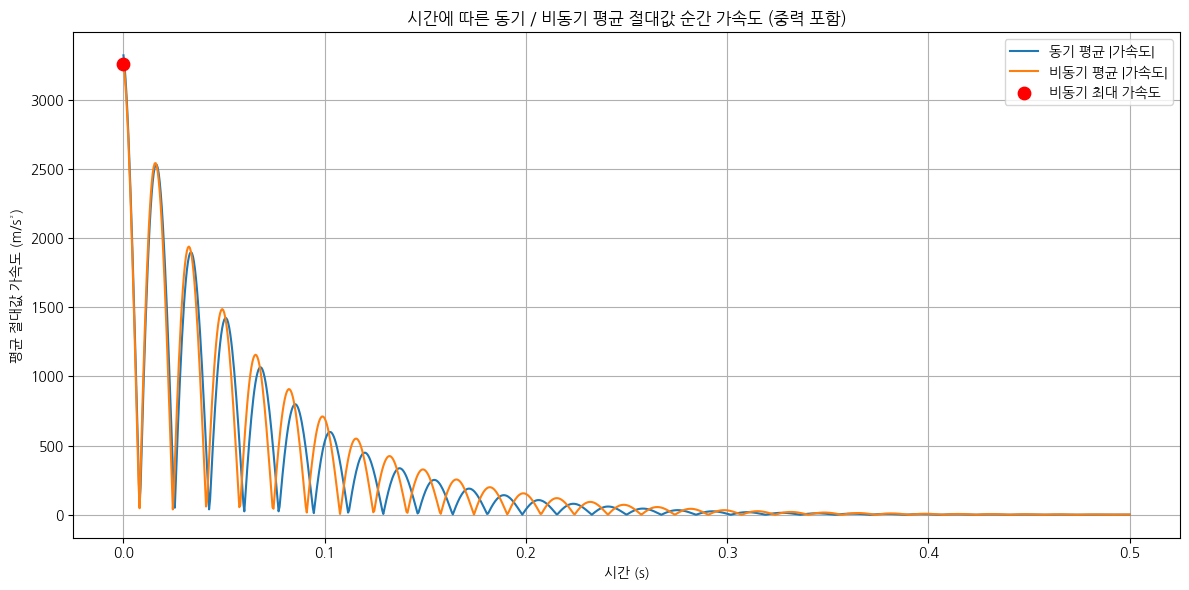

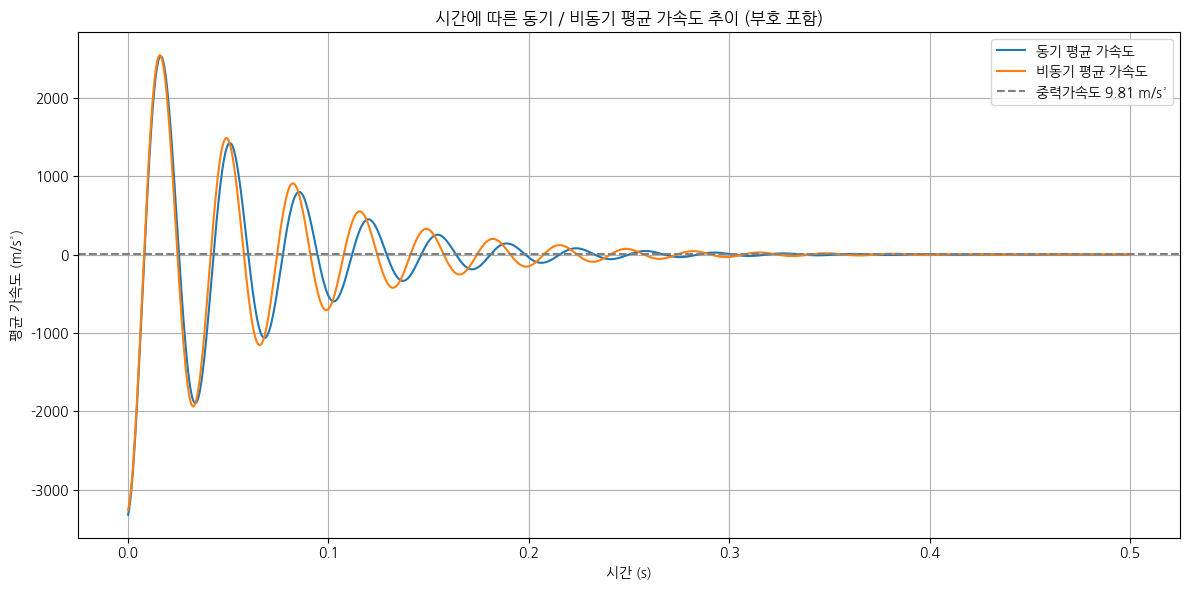

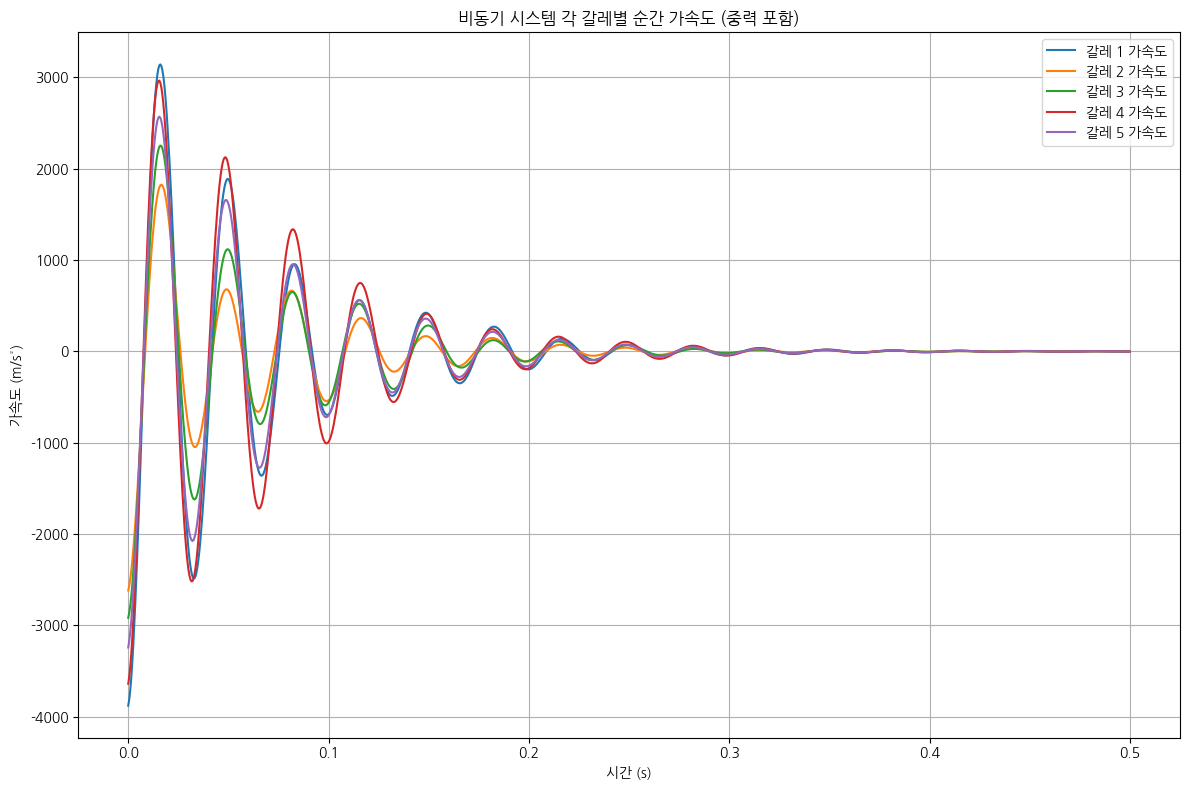

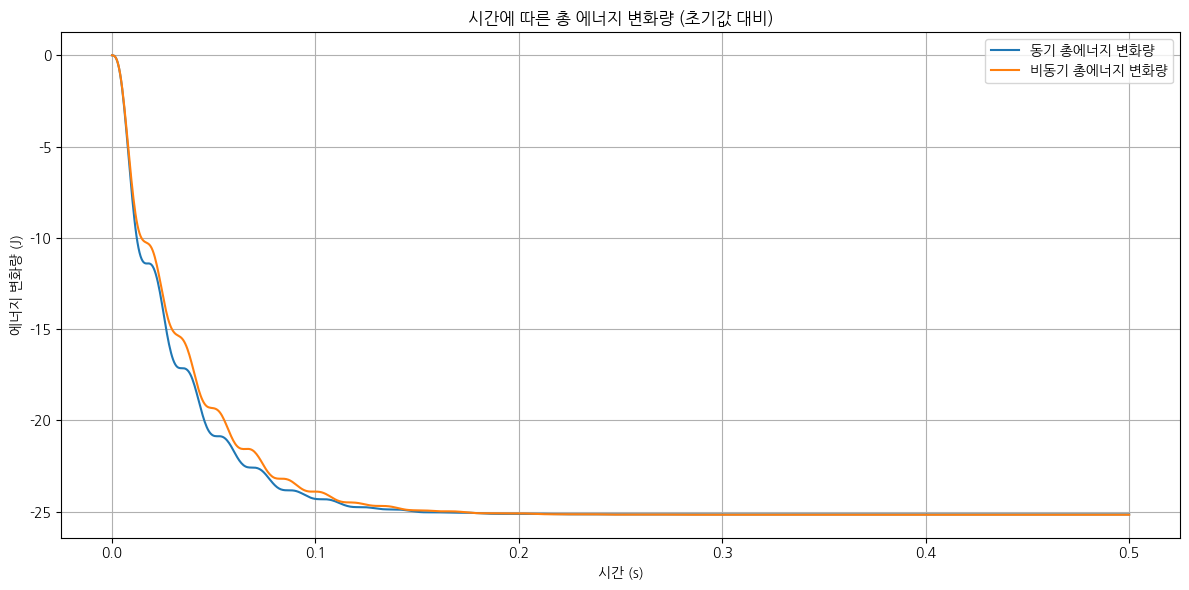

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 시스템 파라미터 설정 ---
N = 5                  # 질량체(갈레)의 개수
k_base = 1000.0        # 스프링 상수 기본값 (N/m)
c_base = 1.0           # 감쇠 계수 기본값 (kg/s)
m_base = 0.03          # 질량 기본값 (kg)
K_int = 100.0          # 상호작용 스프링 상수 (갈레간 연결 스프링 강성)

g = 9.81               # 중력 가속도 (m/s²)
x0 = 0.0               # 평형 위치 (고무줄 원래 길이 기준)
h0 = 0.1               # 초기 높이 (m), 중력 위치에너지 기준점

# 시뮬레이션 시간 구간 설정: 0초부터 0.5초까지
t_span = (0, 0.5)
# 시간 해상도: 0.5초 구간을 1000개의 시간 점으로 나눔
t_eval = np.linspace(*t_span, 1000)

# --- 상호작용 스프링 행렬 생성 ---
# N x N 행렬을 -K_int 로 초기화 (모든 갈레쌍 간 상호작용 강성)
K_matrix = np.full((N, N), -K_int)
np.fill_diagonal(K_matrix, 0)   # 대각선은 자기 자신과의 상호작용 없으므로 0
for i in range(N):
    # 각 행 대각선 원소는 나머지 열의 합의 음수 (대각선 원소 = - sum(비대각 원소))
    # 이렇게 해서 각 갈레에 작용하는 상호작용 힘 합산 가능
    K_matrix[i, i] = -np.sum(K_matrix[i])

# --- 에너지 계산 함수 ---
def compute_energy(x, v, k_i, m_i):
    """
    위치 x, 속도 v, 스프링 상수 k_i, 질량 m_i 배열을 받아서
    각 갈레별 위치에너지(스프링+중력), 운동에너지, 총 에너지 계산하여 반환
    x, v : shape (N, 시간 개수)
    k_i, m_i : shape (N,)
    """
    # 스프링 위치에너지: 0.5 * k * (x - x0)^2, 각 갈레별 에너지 합산
    U_spring = np.sum(0.5 * k_i[:, None] * (x - x0)**2, axis=0)
    # 중력 위치에너지: m * g * x, 갈레별 에너지 합산
    U_gravity = np.sum(m_i[:, None] * g * x, axis=0)
    U = U_spring + U_gravity      # 총 위치에너지
    
    # 운동에너지: 0.5 * m * v^2, 갈레별 합산
    K = np.sum(0.5 * m_i[:, None] * v**2, axis=0)
    return U, K, U + K             # 위치에너지, 운동에너지, 총 에너지 반환

# --- 미분방정식 정의 ---
def spring_damper_system(t, y, k_i, c_i, m_i):
    """
    상태 벡터 y = [x_1,...,x_N, v_1,...,v_N]
    위치와 속도를 받아, 미분방정식의 우변값 반환:
    dx/dt = v
    dv/dt = 가속도 a = F/m (스프링력 + 감쇠력 + 중력 + 상호작용 스프링 힘)
    """
    x = y[:N]    # 위치 벡터
    v = y[N:]    # 속도 벡터
    dxdt = v     # 위치 변화율은 속도와 같음

    # 상호작용 스프링 힘 계산: K_matrix 행렬과 위치 벡터 내적
    interaction = K_matrix @ x

    a = np.zeros(N)  # 가속도 배열 초기화
    for i in range(N):
        # i번째 갈레에 작용하는 힘 계산
        force_spring = -k_i[i] * (x[i] - x0) + interaction[i]   # 스프링 탄성력 + 상호작용 스프링 힘
        force_damping = -c_i[i] * v[i]                          # 감쇠력 (속도에 반비례)
        force_gravity = m_i[i] * g                              # 중력력 (아래 방향)

        total_force = force_spring + force_damping + force_gravity
        a[i] = total_force / m_i[i]                              # 뉴턴 2법칙: a = F / m

    return np.concatenate([dxdt, a])    # 위치 변화율과 가속도 배열 연결하여 반환

# --- 동기 조건 설정 ---
k_sync = np.full(N, k_base)    # 모든 갈레의 스프링 상수 동일
c_sync = np.full(N, c_base)    # 모든 갈레의 감쇠 계수 동일
m_sync = np.full(N, m_base)    # 모든 갈레의 질량 동일

x_init_sync = np.full(N, h0)        # 초기 위치 모두 동일 (h0)
v_init_sync = np.full(N, -0.05)     # 초기 속도 모두 동일 (아래 방향으로)
y0_sync = np.concatenate([x_init_sync, v_init_sync])  # 초기 상태 벡터

# 동기 시스템 ODE 해석 (solve_ivp 사용)
sol_sync = solve_ivp(spring_damper_system, t_span, y0_sync, t_eval=t_eval, args=(k_sync, c_sync, m_sync))
x_sync = sol_sync.y[:N]  # 위치 결과 (N x 시간 개수)
v_sync = sol_sync.y[N:]  # 속도 결과

# 상호작용 스프링 힘 계산 (전체 위치 행렬 곱)
interaction_sync = K_matrix @ x_sync

# 가속도 계산 (속도와 힘으로부터 재계산, 검증 목적)
a_sync = np.zeros_like(x_sync)
for i in range(len(t_eval)):
    for j in range(N):
        force_spring = -k_sync[j] * (x_sync[j, i] - x0) + interaction_sync[j, i]
        force_damping = -c_sync[j] * v_sync[j, i]
        force_gravity = m_sync[j] * g
        a_sync[j, i] = (force_spring + force_damping + force_gravity) / m_sync[j]

# 시간별 모든 갈레 평균 가속도 계산
mean_accel_sync = np.mean(a_sync, axis=0)

# 위치, 속도, 파라미터로 에너지 계산 (위치에너지, 운동에너지, 총에너지)
U_sync, K_sync, E_sync = compute_energy(x_sync, v_sync, k_sync, m_sync)

# --- 비동기 조건 설정 ---
np.random.seed(0)  # 난수 시드 고정 (재현성)

# 각 파라미터에 랜덤 노이즈 추가 (비동기성 부여)
k_async = k_base + 100 * np.random.randn(N)     # 스프링 상수 랜덤 변동
c_async = c_base + 0.2 * np.random.randn(N)     # 감쇠 계수 랜덤 변동
m_async = m_base + 0.005 * np.random.randn(N)   # 질량 랜덤 변동

# 초기 위치도 약간 다르게 설정
x_init_async = h0 + 0.005 * np.random.randn(N)
v_init_async = np.full(N, -0.05)                 # 속도는 동일
x_init_async[0] += 0.02                          # 첫 번째 갈레 위치만 약간 추가 변경

# 동기 초기 위치와 동일한 총 위치에너지를 맞추기 위해 초기 위치 스케일 조정
U_target = np.sum(0.5 * k_sync * (x_init_sync - x0)**2 + m_sync * g * x_init_sync)
U_current = np.sum(0.5 * k_async * (x_init_async - x0)**2 + m_async * g * x_init_async)
scale = np.sqrt(U_target / U_current)    # 에너지 보존을 위한 위치 스케일링 계수
x_init_async = x0 + (x_init_async - x0) * scale

y0_async = np.concatenate([x_init_async, v_init_async])  # 초기 상태 벡터

# 비동기 시스템 ODE 해석
sol_async = solve_ivp(spring_damper_system, t_span, y0_async, t_eval=t_eval, args=(k_async, c_async, m_async))
x_async = sol_async.y[:N]
v_async = sol_async.y[N:]

interaction_async = K_matrix @ x_async

a_async = np.zeros_like(x_async)
for i in range(len(t_eval)):
    for j in range(N):
        force_spring = -k_async[j] * (x_async[j, i] - x0) + interaction_async[j, i]
        force_damping = -c_async[j] * v_async[j, i]
        force_gravity = m_async[j] * g
        a_async[j, i] = (force_spring + force_damping + force_gravity) / m_async[j]

mean_accel_async = np.mean(a_async, axis=0)

U_async, K_async, E_async = compute_energy(x_async, v_async, k_async, m_async)

# --- 평균 절대값 및 최대 가속도 계산 및 출력 ---
mean_abs_accel_sync = np.mean(np.abs(mean_accel_sync))
mean_abs_accel_async = np.mean(np.abs(mean_accel_async))
ratio_mean = mean_abs_accel_async / mean_abs_accel_sync

max_abs_accel_sync = np.max(np.abs(mean_accel_sync))
max_abs_accel_async = np.max(np.abs(mean_accel_async))
ratio_max = max_abs_accel_async / max_abs_accel_sync

last_mean_accel_sync = mean_accel_sync[-1]
last_mean_accel_async = mean_accel_async[-1]

print(f"동기 평균 |가속도|: {mean_abs_accel_sync:.4f}")
print(f"비동기 평균 |가속도|: {mean_abs_accel_async:.4f}")
print(f"비동기 / 동기 평균 비율: {ratio_mean:.4f}")
print()
print(f"동기 최대 |가속도|: {max_abs_accel_sync:.4f}")
print(f"비동기 최대 |가속도|: {max_abs_accel_async:.4f}")
print(f"비동기 / 동기 최대 비율: {ratio_max:.4f}")
print()
print(f"동기 마지막 평균 가속도: {last_mean_accel_sync:.4f} (기대값: {g})")
print(f"비동기 마지막 평균 가속도: {last_mean_accel_async:.4f} (기대값: {g})")

# --- 그래프: 평균 절대값 순간 가속도 ---
plt.figure(figsize=(12, 6))
plt.plot(t_eval, np.abs(mean_accel_sync), label='동기 평균 |가속도|')
plt.plot(t_eval, np.abs(mean_accel_async), label='비동기 평균 |가속도|')

# 비동기 최대 가속도 위치 표시 (붉은 점)
max_idx = np.argmax(np.abs(mean_accel_async))
plt.scatter(t_eval[max_idx], np.abs(mean_accel_async)[max_idx], color='red', s=80, label='비동기 최대 가속도', zorder=5)

plt.title('시간에 따른 동기 / 비동기 평균 절대값 순간 가속도 (중력 포함)')
plt.xlabel('시간 (s)')
plt.ylabel('평균 절대값 가속도 (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 그래프: 평균 가속도 (부호 포함) 추이 ---
plt.figure(figsize=(12, 6))
plt.plot(t_eval, mean_accel_sync, label='동기 평균 가속도')
plt.plot(t_eval, mean_accel_async, label='비동기 평균 가속도')
plt.axhline(y=g, color='gray', linestyle='--', label='중력가속도 9.81 m/s²')

plt.title('시간에 따른 동기 / 비동기 평균 가속도 추이 (부호 포함)')
plt.xlabel('시간 (s)')
plt.ylabel('평균 가속도 (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 그래프: 비동기 각 갈레별 순간 가속도 ---
plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, a_async[i], label=f'갈레 {i+1} 가속도')
plt.title('비동기 시스템 각 갈레별 순간 가속도 (중력 포함)')
plt.xlabel('시간 (s)')
plt.ylabel('가속도 (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 에너지 변화량 계산 ---
# 초기 총에너지 대비 각 시점의 총에너지 변화량 계산
delta_E_sync = E_sync - E_sync[0]
delta_E_async = E_async - E_async[0]

# --- 그래프: 총 에너지 변화량 ---
plt.figure(figsize=(12,6))
plt.plot(t_eval, delta_E_sync, label='동기 총에너지 변화량')
plt.plot(t_eval, delta_E_async, label='비동기 총에너지 변화량')
plt.title('시간에 따른 총 에너지 변화량 (초기값 대비)')
plt.xlabel('시간 (s)')
plt.ylabel('에너지 변화량 (J)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


동기 질량 총합: 1.0
동기 스프링 상수 총합: 250.0
비동기 질량 총합: 1.0037
비동기 스프링 상수 총합: 273.1758
비동기 감쇠 계수 총합: 2.4717
동기 조건 최대 가속도: 240.2000 m/s^2
비동기 조건 최대 가속도: 262.3571 m/s^2
비동기 최대 가속도 / 동기 최대 가속도 비율: 1.092


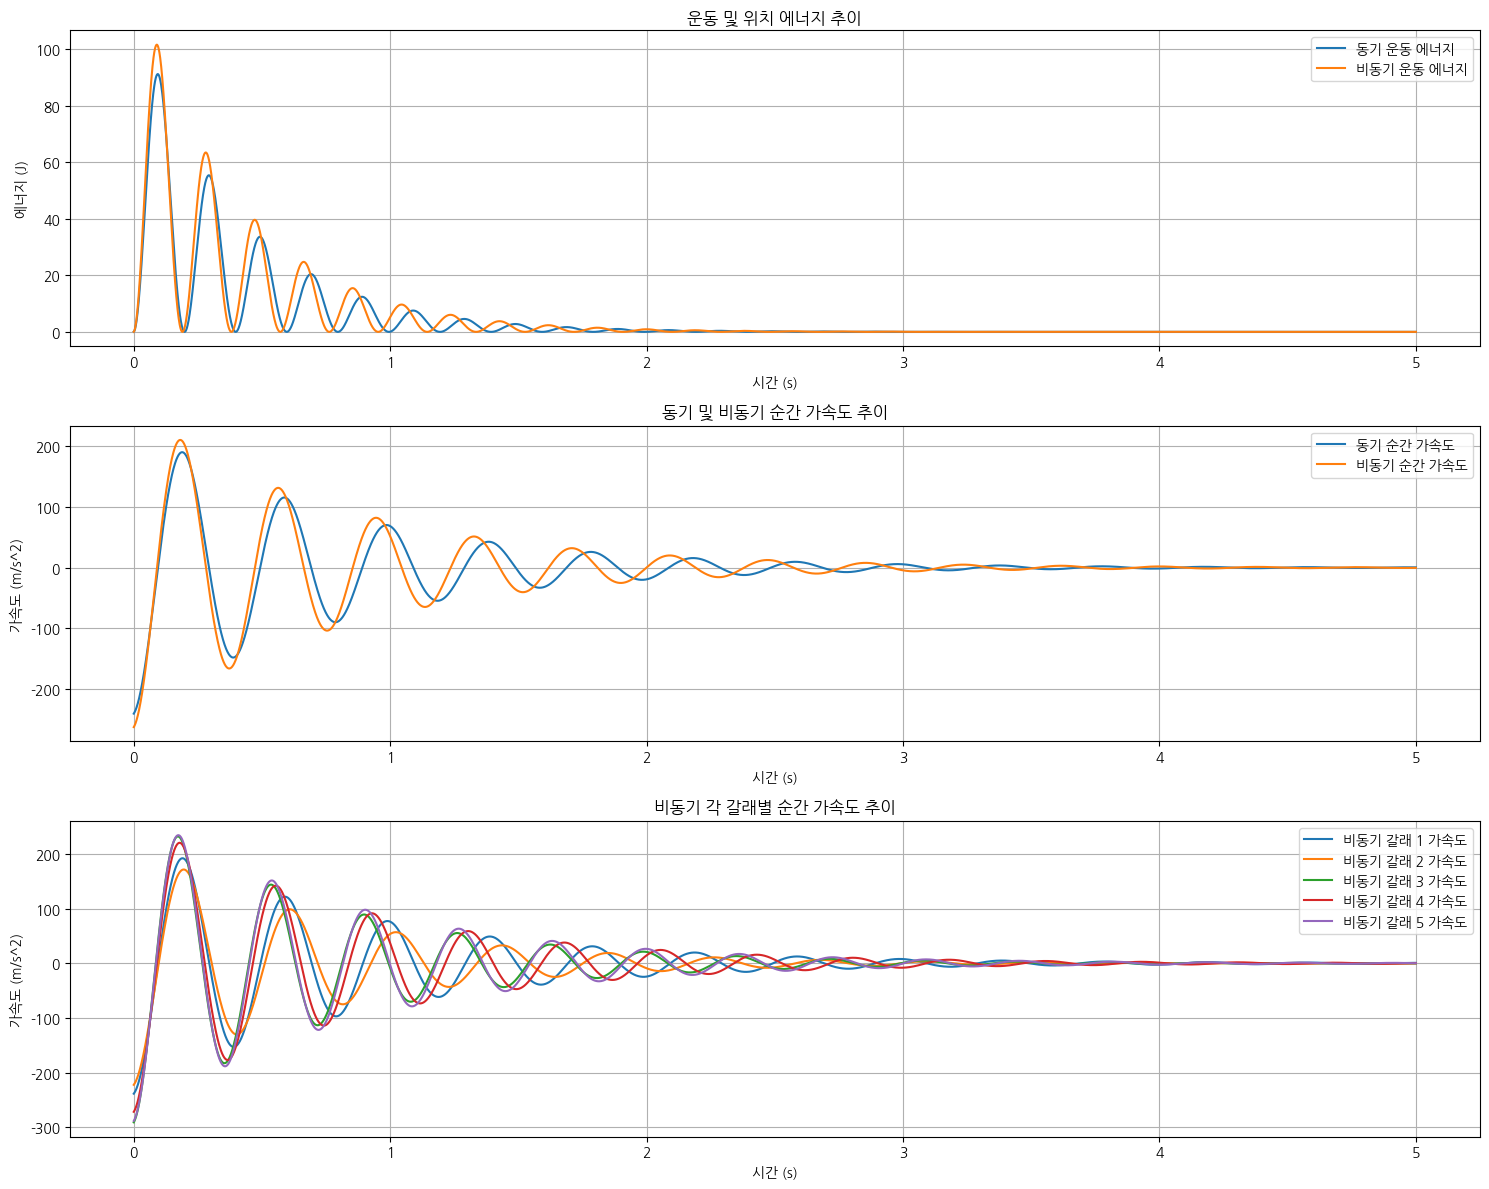

In [31]:
import numpy as np
import matplotlib.pyplot as plt

g = 9.8
n_springs = 5
dt = 0.001
T_total = 5.0
steps = int(T_total / dt)
y0 = 1.0

mass_sync = 1.0  # 전체 질량
k_sync = 50.0    # 각 고무줄 스프링 상수
c_sync = 0.5     # 각 고무줄 감쇠 계수

np.random.seed(42)

mass_per_spring_sync = mass_sync / n_springs
mass_async = mass_per_spring_sync * (1 + 0.06 * (np.random.rand(n_springs) - 0.5))

k_base = k_sync * n_springs * 1.1  # 50*5*1.1=275
k_async = (k_base / n_springs) * (1 + 0.3 * (np.random.rand(n_springs) - 0.5))

c_async = c_sync * (1 + 0.2 * (np.random.rand(n_springs) - 0.5))

mass_total_async = np.sum(mass_async)
k_total_sync = n_springs * k_sync
c_total_sync = n_springs * c_sync
k_total_async = np.sum(k_async)
c_total_async = np.sum(c_async)

print(f"동기 질량 총합: {mass_sync}")
print(f"동기 스프링 상수 총합: {k_total_sync}")
print(f"비동기 질량 총합: {mass_total_async:.4f}")
print(f"비동기 스프링 상수 총합: {k_total_async:.4f}")
print(f"비동기 감쇠 계수 총합: {np.sum(c_async):.4f}")

y_sync = y0
v_sync = 0.0
y_async = y0
v_async = 0.0

time = np.linspace(0, T_total, steps)
KE_sync = np.zeros(steps)
PE_sync = np.zeros(steps)
acc_sync = np.zeros(steps)
KE_async = np.zeros(steps)
PE_async = np.zeros(steps)
acc_async = np.zeros(steps)

# 비동기 각 갈래별 속도, 위치, 가속도 배열 초기화
v_async_each = np.zeros(n_springs)
y_async_each = np.ones(n_springs) * y0
acc_async_each = np.zeros((n_springs, steps))

for i in range(steps):
    # 동기 조건 가속도 계산
    F_spring_sync = -k_total_sync * y_sync
    F_damping_sync = -c_total_sync * v_sync
    F_gravity_sync = mass_sync * g

    a_sync = (F_gravity_sync + F_spring_sync + F_damping_sync) / mass_sync
    v_sync += a_sync * dt
    y_sync += v_sync * dt

    KE_sync[i] = 0.5 * mass_sync * v_sync**2
    PE_sync[i] = 0.5 * k_total_sync * y_sync**2
    acc_sync[i] = a_sync

    # 비동기 조건 가속도 계산 (전체 평균)
    F_spring_async_total = -k_total_async * y_async
    F_damping_async_total = -c_total_async * v_async
    F_gravity_async_total = mass_total_async * g

    a_async = (F_gravity_async_total + F_spring_async_total + F_damping_async_total) / mass_total_async
    v_async += a_async * dt
    y_async += v_async * dt

    KE_async[i] = 0.5 * mass_total_async * v_async**2
    PE_async[i] = 0.5 * k_total_async * y_async**2
    acc_async[i] = a_async

    # 비동기 각 갈래별 가속도, 속도, 위치 계산
    for j in range(n_springs):
        F_spring_j = -k_async[j] * y_async_each[j]
        F_damping_j = -c_async[j] * v_async_each[j]
        F_gravity_j = mass_async[j] * g

        a_j = (F_gravity_j + F_spring_j + F_damping_j) / mass_async[j]
        v_async_each[j] += a_j * dt
        y_async_each[j] += v_async_each[j] * dt
        acc_async_each[j, i] = a_j

print(f"동기 조건 최대 가속도: {np.max(np.abs(acc_sync)):.4f} m/s^2")
print(f"비동기 조건 최대 가속도: {np.max(np.abs(acc_async)):.4f} m/s^2")
print(f"비동기 최대 가속도 / 동기 최대 가속도 비율: {np.max(np.abs(acc_async))/np.max(np.abs(acc_sync)):.3f}")

plt.figure(figsize=(15,12))

plt.subplot(3,1,1)
plt.plot(time, KE_sync, label='동기 운동 에너지')
plt.plot(time, KE_async, label='비동기 운동 에너지')
# plt.plot(time, PE_sync, '--', label='동기 위치 에너지')
# plt.plot(time, PE_async, '--', label='비동기 위치 에너지')
plt.title('운동 및 위치 에너지 추이')
plt.xlabel('시간 (s)')
plt.ylabel('에너지 (J)')
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot(time, acc_sync, label='동기 순간 가속도')
plt.plot(time, acc_async, label='비동기 순간 가속도')
plt.title('동기 및 비동기 순간 가속도 추이')
plt.xlabel('시간 (s)')
plt.ylabel('가속도 (m/s^2)')
plt.legend()
plt.grid()

plt.subplot(3,1,3)
for j in range(n_springs):
    plt.plot(time, acc_async_each[j], label=f'비동기 갈래 {j+1} 가속도')
plt.title('비동기 각 갈래별 순간 가속도 추이')
plt.xlabel('시간 (s)')
plt.ylabel('가속도 (m/s^2)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


동기 평균 |가속도|: 254.9638
비동기 평균 |가속도|: 268.4246
비동기 / 동기 평균 비율: 1.0528

동기 최대 |가속도|: 3321.8567
비동기 최대 |가속도|: 3259.3906
비동기 / 동기 최대 비율: 0.9812

동기 마지막 평균 가속도: 0.7848 (기대값: 9.81)
비동기 마지막 평균 가속도: -1.5081 (기대값: 9.81)


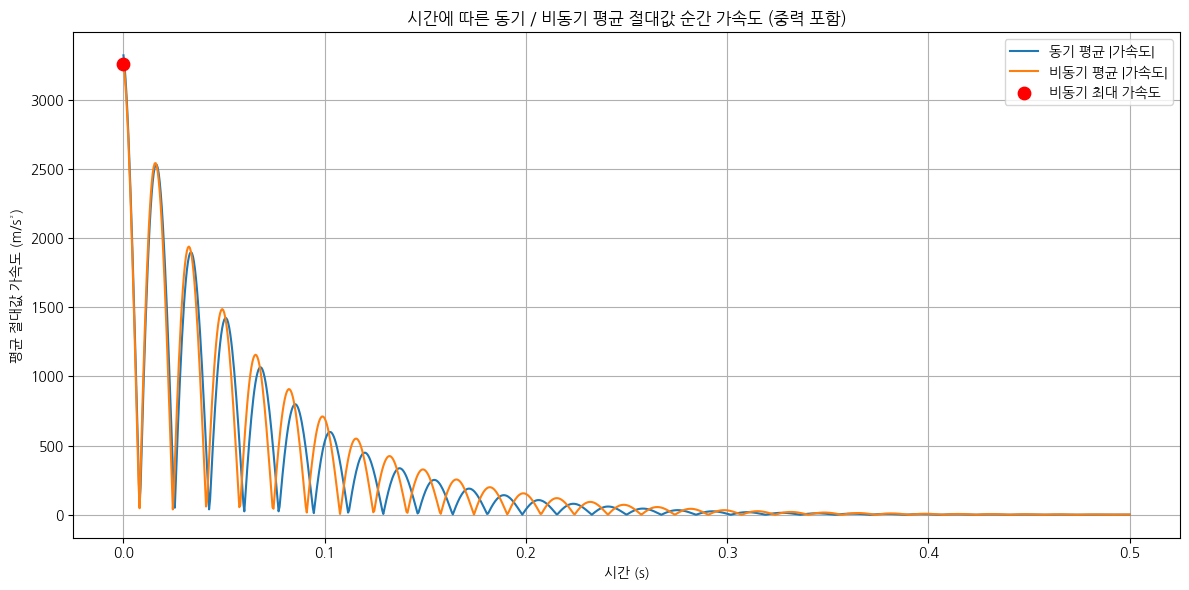

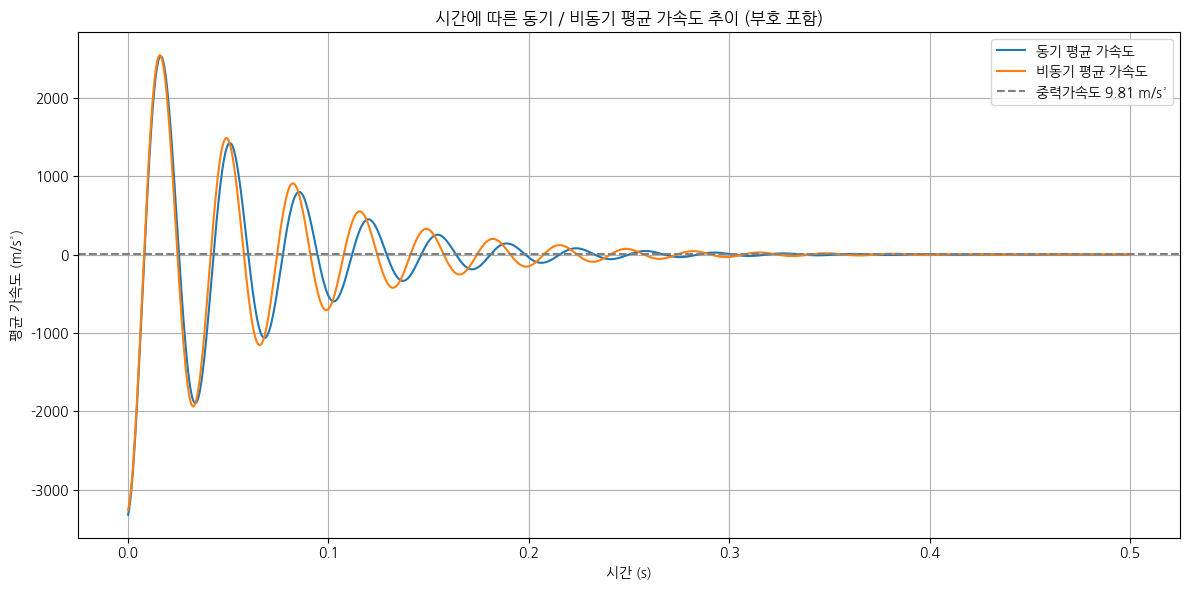

Text(0.5, 0, '시간 (s)')

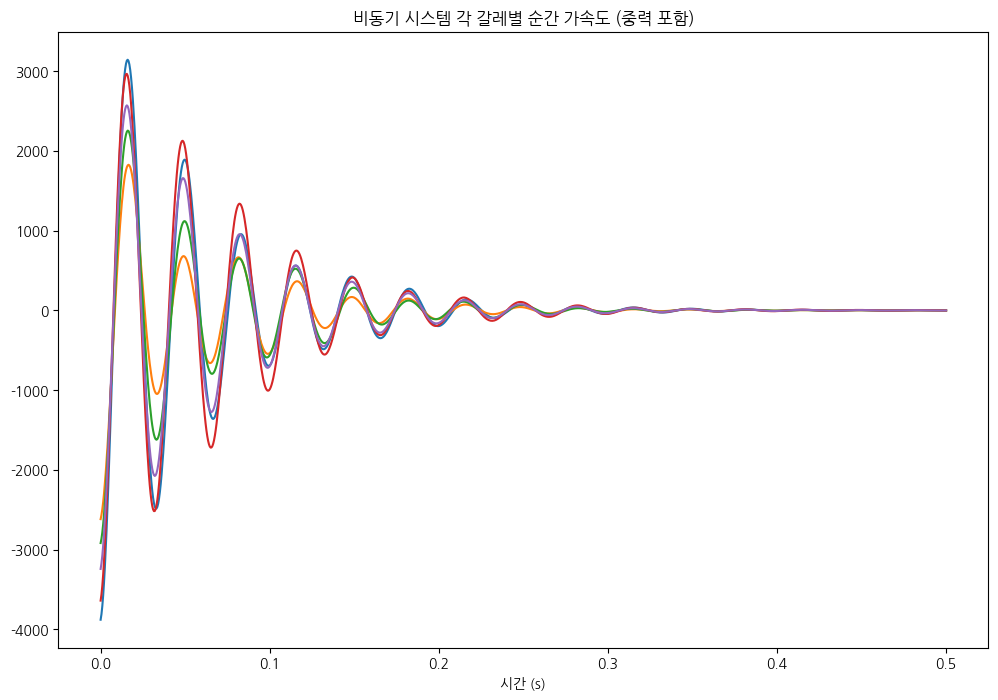

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 시스템 파라미터 설정 ---
N = 5                  # 질량체(갈레) 개수
k_base = 1000.0        # 스프링 상수 기본값
c_base = 1.0           # 감쇠 계수 기본값
m_base = 0.03          # 질량 기본값
K_int = 100.0          # 상호작용 스프링 상수

g = 9.81               # 중력가속도 (m/s^2)
x0 = 0.0               # 평형 위치 (고무줄 원래 길이 기준)
h0 = 0.1               # 초기 높이 (m) - 중력 위치에너지의 기준

# 시간 구간 설정 (0초부터 0.5초까지)
t_span = (0, 0.5)
t_eval = np.linspace(*t_span, 1000)  # 1000개 점으로 시간평가

# --- 상호작용 스프링 행렬 생성 ---
# 모든 비대각선 원소에 -K_int 값을 넣고, 각 행 대각선 원소는 행의 나머지 합을 음수로 하여
# 각 질량체에 대한 상호작용 힘을 표현
K_matrix = np.full((N, N), -K_int)
np.fill_diagonal(K_matrix, 0)
for i in range(N):
    K_matrix[i, i] = -np.sum(K_matrix[i])

# --- 에너지 계산 함수 ---
def compute_energy(x, v, k_i, m_i):
    """
    위치 x, 속도 v, 스프링 상수 k_i, 질량 m_i 배열로부터
    위치에너지 (스프링+중력), 운동에너지, 총에너지 반환
    """
    U_spring = np.sum(0.5 * k_i[:, None] * (x - x0)**2, axis=0)  # 스프링 위치에너지
    U_gravity = np.sum(m_i[:, None] * g * x, axis=0)             # 중력 위치에너지
    U = U_spring + U_gravity                                     # 총 위치에너지
    K = np.sum(0.5 * m_i[:, None] * v**2, axis=0)                # 운동에너지
    return U, K, U + K

# --- 미분방정식 정의 ---
def spring_damper_system(t, y, k_i, c_i, m_i):
    """
    상태 y = [x_1,...x_N, v_1,...v_N]
    운동방정식 dx/dt = v, dv/dt = a 를 계산함
    힘은 스프링 탄성력 + 감쇠력 + 중력 + 상호작용 스프링힘을 포함
    """
    x = y[:N]    # 위치
    v = y[N:]    # 속도
    dxdt = v     # 위치 변화율은 속도

    interaction = K_matrix @ x    # 상호작용 스프링 힘 계산

    a = np.zeros(N)  # 가속도 배열 초기화
    for i in range(N):
        # 스프링 힘: -k(x - x0) + 상호작용
        force_spring = -k_i[i] * (x[i] - x0) + interaction[i]
        # 감쇠 힘: -c * v
        force_damping = -c_i[i] * v[i]
        # 중력 힘: m * g (아래 방향)
        force_gravity = m_i[i] * g

        total_force = force_spring + force_damping + force_gravity
        a[i] = total_force / m_i[i]  # 뉴턴 2법칙: a = F/m

    return np.concatenate([dxdt, a])

# --- 동기 조건 설정 ---
k_sync = np.full(N, k_base)    # 동기 스프링 상수 동일
c_sync = np.full(N, c_base)    # 동기 감쇠 계수 동일
m_sync = np.full(N, m_base)    # 동기 질량 동일

x_init_sync = np.full(N, h0)   # 모두 같은 초기 높이
v_init_sync = np.full(N, -0.05)  # 초기 아래 방향 속도 (낙하 시작)
y0_sync = np.concatenate([x_init_sync, v_init_sync])  # 초기 상태 벡터

# 동기 시스템 해석 (ODE 풀기)
sol_sync = solve_ivp(spring_damper_system, t_span, y0_sync, t_eval=t_eval, args=(k_sync, c_sync, m_sync))
x_sync = sol_sync.y[:N]  # 위치 결과
v_sync = sol_sync.y[N:]  # 속도 결과

# 각 시점별 상호작용 힘 계산
interaction_sync = K_matrix @ x_sync

# 가속도 계산 (수치 결과 검증용)
a_sync = np.zeros_like(x_sync)
for i in range(len(t_eval)):
    for j in range(N):
        force_spring = -k_sync[j] * (x_sync[j, i] - x0) + interaction_sync[j, i]
        force_damping = -c_sync[j] * v_sync[j, i]
        force_gravity = m_sync[j] * g
        a_sync[j, i] = (force_spring + force_damping + force_gravity) / m_sync[j]

mean_accel_sync = np.mean(a_sync, axis=0)  # 갈레별 평균 가속도 (시간 함수)
U_sync, K_sync, E_sync = compute_energy(x_sync, v_sync, k_sync, m_sync)  # 에너지 계산

# --- 비동기 조건 설정 ---
np.random.seed(0)
# 비동기성 부여 (스프링 상수, 감쇠, 질량에 랜덤 노이즈 추가)
k_async = k_base + 100 * np.random.randn(N)
c_async = c_base + 0.2 * np.random.randn(N)
m_async = m_base + 0.005 * np.random.randn(N)

x_init_async = h0 + 0.005 * np.random.randn(N)  # 초기 위치 약간 변동
v_init_async = np.full(N, -0.05)                # 초기 속도 동일

x_init_async[0] += 0.02  # 한 개는 조금 더 초기 위치 조정

# 동기와 같은 총 위치에너지 기준으로 초기 위치 보정
U_target = np.sum(0.5 * k_sync * (x_init_sync - x0)**2 + m_sync * g * x_init_sync)
U_current = np.sum(0.5 * k_async * (x_init_async - x0)**2 + m_async * g * x_init_async)
scale = np.sqrt(U_target / U_current)
x_init_async = x0 + (x_init_async - x0) * scale

y0_async = np.concatenate([x_init_async, v_init_async])

# 비동기 시스템 해석
sol_async = solve_ivp(spring_damper_system, t_span, y0_async, t_eval=t_eval, args=(k_async, c_async, m_async))
x_async = sol_async.y[:N]
v_async = sol_async.y[N:]

interaction_async = K_matrix @ x_async

a_async = np.zeros_like(x_async)
for i in range(len(t_eval)):
    for j in range(N):
        force_spring = -k_async[j] * (x_async[j, i] - x0) + interaction_async[j, i]
        force_damping = -c_async[j] * v_async[j, i]
        force_gravity = m_async[j] * g
        a_async[j, i] = (force_spring + force_damping + force_gravity) / m_async[j]

mean_accel_async = np.mean(a_async, axis=0)
U_async, K_async, E_async = compute_energy(x_async, v_async, k_async, m_async)

# --- 평균 절대값 및 최대 가속도 계산 ---
mean_abs_accel_sync = np.mean(np.abs(mean_accel_sync))
mean_abs_accel_async = np.mean(np.abs(mean_accel_async))
ratio_mean = mean_abs_accel_async / mean_abs_accel_sync

max_abs_accel_sync = np.max(np.abs(mean_accel_sync))
max_abs_accel_async = np.max(np.abs(mean_accel_async))
ratio_max = max_abs_accel_async / max_abs_accel_sync

last_mean_accel_sync = mean_accel_sync[-1]
last_mean_accel_async = mean_accel_async[-1]

# 결과 출력
print(f"동기 평균 |가속도|: {mean_abs_accel_sync:.4f}")
print(f"비동기 평균 |가속도|: {mean_abs_accel_async:.4f}")
print(f"비동기 / 동기 평균 비율: {ratio_mean:.4f}")
print()
print(f"동기 최대 |가속도|: {max_abs_accel_sync:.4f}")
print(f"비동기 최대 |가속도|: {max_abs_accel_async:.4f}")
print(f"비동기 / 동기 최대 비율: {ratio_max:.4f}")
print()
print(f"동기 마지막 평균 가속도: {last_mean_accel_sync:.4f} (기대값: {g})")
print(f"비동기 마지막 평균 가속도: {last_mean_accel_async:.4f} (기대값: {g})")

# --- 그래프: 평균 절대값 순간 가속도 ---
plt.figure(figsize=(12, 6))
plt.plot(t_eval, np.abs(mean_accel_sync), label='동기 평균 |가속도|')
plt.plot(t_eval, np.abs(mean_accel_async), label='비동기 평균 |가속도|')

# 비동기 최대 가속도 위치 표시 (빨간 점)
max_idx = np.argmax(np.abs(mean_accel_async))
plt.scatter(t_eval[max_idx], np.abs(mean_accel_async)[max_idx], color='red', s=80, label='비동기 최대 가속도', zorder=5)

plt.title('시간에 따른 동기 / 비동기 평균 절대값 순간 가속도 (중력 포함)')
plt.xlabel('시간 (s)')
plt.ylabel('평균 절대값 가속도 (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 그래프: 평균 가속도 (부호 포함) 추이 ---
plt.figure(figsize=(12, 6))
plt.plot(t_eval, mean_accel_sync, label='동기 평균 가속도')
plt.plot(t_eval, mean_accel_async, label='비동기 평균 가속도')
plt.axhline(y=g, color='gray', linestyle='--', label='중력가속도 9.81 m/s²')

plt.title('시간에 따른 동기 / 비동기 평균 가속도 추이 (부호 포함)')
plt.xlabel('시간 (s)')
plt.ylabel('평균 가속도 (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 그래프: 비동기 각 갈레별 순간 가속도 ---
plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, a_async[i], label=f'갈레 {i+1} 가속도')
plt.title('비동기 시스템 각 갈레별 순간 가속도 (중력 포함)')
plt.xlabel('시간 (s)')


동기 평균 |가속도|: 51.1540
비동기 평균 |가속도|: 72.8798
비동기 / 동기 평균 비율: 1.4247

동기 최대 |가속도|: 666.6667
비동기 최대 |가속도|: 878.4882
비동기 / 동기 최대 비율: 1.3177


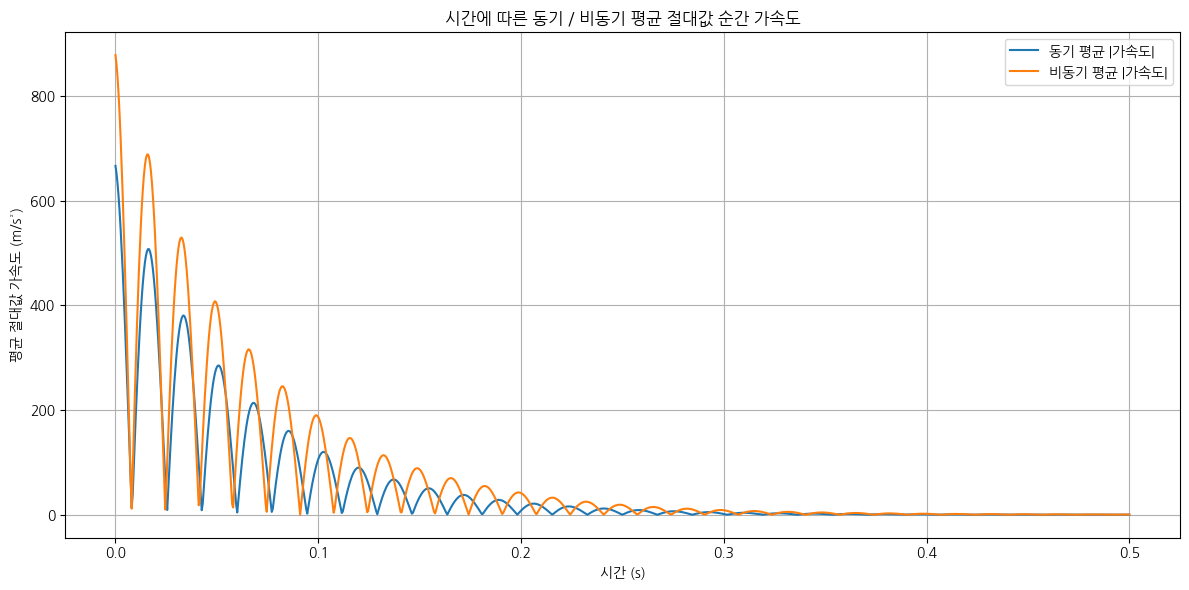

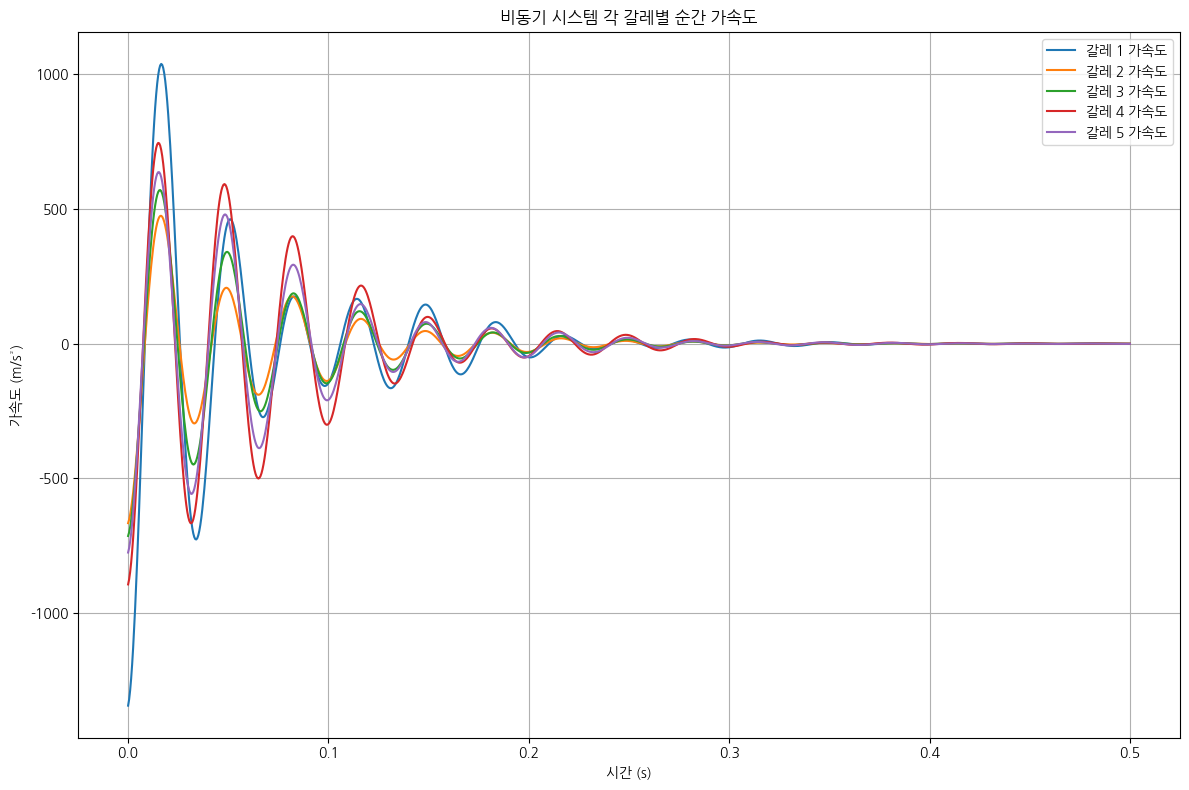

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 시스템 파라미터 ---
N = 5
k_base = 1000.0
c_base = 1.0
m_base = 0.03
K_int = 100.0
x0 = 0.0

# 시간 설정
t_span = (0, 0.5)
t_eval = np.linspace(*t_span, 1000)

# 상호작용 행렬
K_matrix = np.full((N, N), -K_int)
np.fill_diagonal(K_matrix, 0)
for i in range(N):
    K_matrix[i, i] = -np.sum(K_matrix[i])

# --- 에너지 계산 함수 ---
def compute_energy(x, v, k_i, m_i):
    U = np.sum(0.5 * k_i[:, None] * (x - x0)**2, axis=0)
    K = np.sum(0.5 * m_i[:, None] * v**2, axis=0)
    return U, K, U + K

# --- 시스템 정의 ---
def spring_damper_system(t, y, k_i, c_i, m_i):
    x = y[:N]
    v = y[N:]
    dxdt = v
    interaction = K_matrix @ x
    a = np.zeros(N)
    for i in range(N):
        a[i] = (-k_i[i] * (x[i] - x0) - c_i[i] * v[i] + interaction[i]) / m_i[i]
    return np.concatenate([dxdt, a])

# ------------------- 동기 상태 -------------------
k_sync = np.full(N, k_base)
c_sync = np.full(N, c_base)
m_sync = np.full(N, m_base)

x_init_sync = np.full(N, 0.02)
v_init_sync = np.zeros(N)
y0_sync = np.concatenate([x_init_sync, v_init_sync])

sol_sync = solve_ivp(spring_damper_system, t_span, y0_sync, t_eval=t_eval, args=(k_sync, c_sync, m_sync))
x_sync = sol_sync.y[:N]
v_sync = sol_sync.y[N:]

interaction_sync = K_matrix @ x_sync
a_sync = np.zeros_like(x_sync)
for i in range(len(t_eval)):
    for j in range(N):
        a_sync[j, i] = (-k_sync[j] * (x_sync[j, i] - x0) - c_sync[j] * v_sync[j, i] + interaction_sync[j, i]) / m_sync[j]

mean_accel_sync = np.mean(a_sync, axis=0)
U_sync, K_sync, E_sync = compute_energy(x_sync, v_sync, k_sync, m_sync)

# ------------------- 비동기 상태 -------------------
np.random.seed(0)

k_async = k_base + 100 * np.random.randn(N)
c_async = c_base + 0.2 * np.random.randn(N)
m_async = m_base + 0.005 * np.random.randn(N)

x_init_async = 0.02 + 0.002 * np.random.randn(N)
x_init_async[0] += 0.022  # 앞서 조정한 값

v_init_async = np.zeros(N)

y0_async = np.concatenate([x_init_async, v_init_async])

sol_async = solve_ivp(spring_damper_system, t_span, y0_async, t_eval=t_eval, args=(k_async, c_async, m_async))
x_async = sol_async.y[:N]
v_async = sol_async.y[N:]

interaction_async = K_matrix @ x_async
a_async = np.zeros_like(x_async)
for i in range(len(t_eval)):
    for j in range(N):
        a_async[j, i] = (-k_async[j] * (x_async[j, i] - x0) - c_async[j] * v_async[j, i] + interaction_async[j, i]) / m_async[j]

mean_accel_async = np.mean(a_async, axis=0)
U_async, K_async, E_async = compute_energy(x_async, v_async, k_async, m_async)

# --- 평균 절대값 가속도 계산 ---
mean_abs_accel_sync = np.mean(np.abs(mean_accel_sync))
mean_abs_accel_async = np.mean(np.abs(mean_accel_async))
ratio = mean_abs_accel_async / mean_abs_accel_sync

max_abs_accel_sync = np.max(np.abs(mean_accel_sync))
max_abs_accel_async = np.max(np.abs(mean_accel_async))
max_ratio = max_abs_accel_async / max_abs_accel_sync

print(f"동기 평균 |가속도|: {mean_abs_accel_sync:.4f}")
print(f"비동기 평균 |가속도|: {mean_abs_accel_async:.4f}")
print(f"비동기 / 동기 평균 비율: {ratio:.4f}")
print()
print(f"동기 최대 |가속도|: {max_abs_accel_sync:.4f}")
print(f"비동기 최대 |가속도|: {max_abs_accel_async:.4f}")
print(f"비동기 / 동기 최대 비율: {max_ratio:.4f}")

# --- 그래프 그리기 ---

plt.figure(figsize=(12, 6))
plt.plot(t_eval, np.abs(mean_accel_sync), label='동기 평균 |가속도|')
plt.plot(t_eval, np.abs(mean_accel_async), label='비동기 평균 |가속도|')
plt.title('시간에 따른 동기 / 비동기 평균 절대값 순간 가속도')
plt.xlabel('시간 (s)')
plt.ylabel('평균 절대값 가속도 (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 비동기 각 갈레별 가속도 시간 추이 그래프 ---
plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, a_async[i], label=f'갈레 {i+1} 가속도')
plt.title('비동기 시스템 각 갈레별 순간 가속도')
plt.xlabel('시간 (s)')
plt.ylabel('가속도 (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


동기 평균 |가속도|: 255.0434
비동기 평균 |가속도|: 268.5190
비동기 / 동기 평균 비율: 1.0528

동기 최대 |가속도|: 3323.5233
비동기 최대 |가속도|: 3260.9145
비동기 / 동기 최대 비율: 0.9812


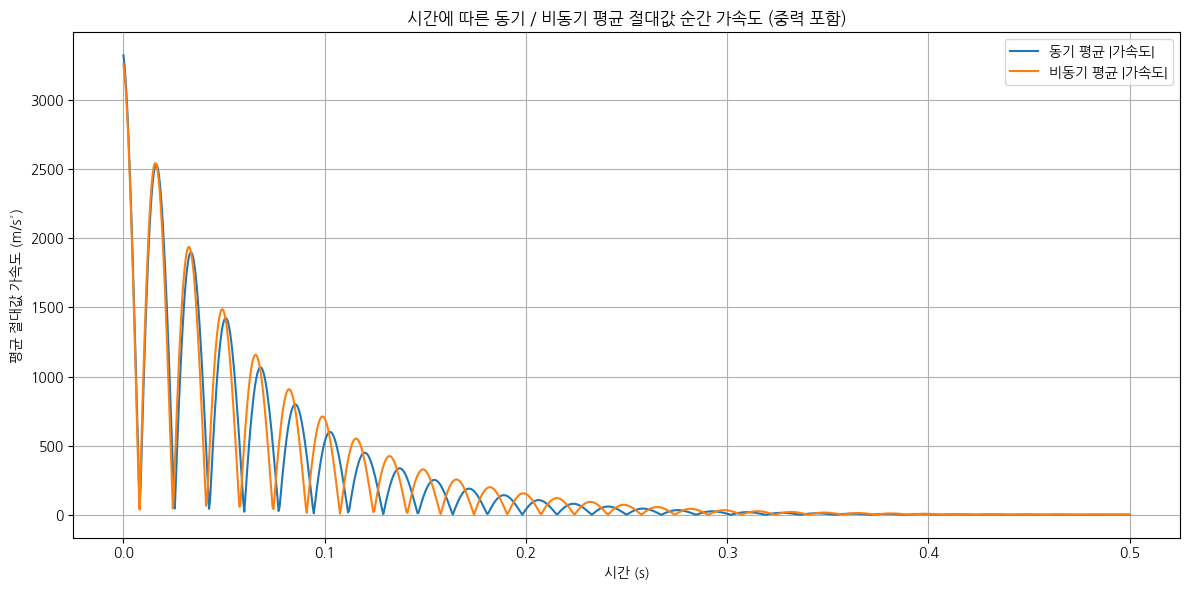

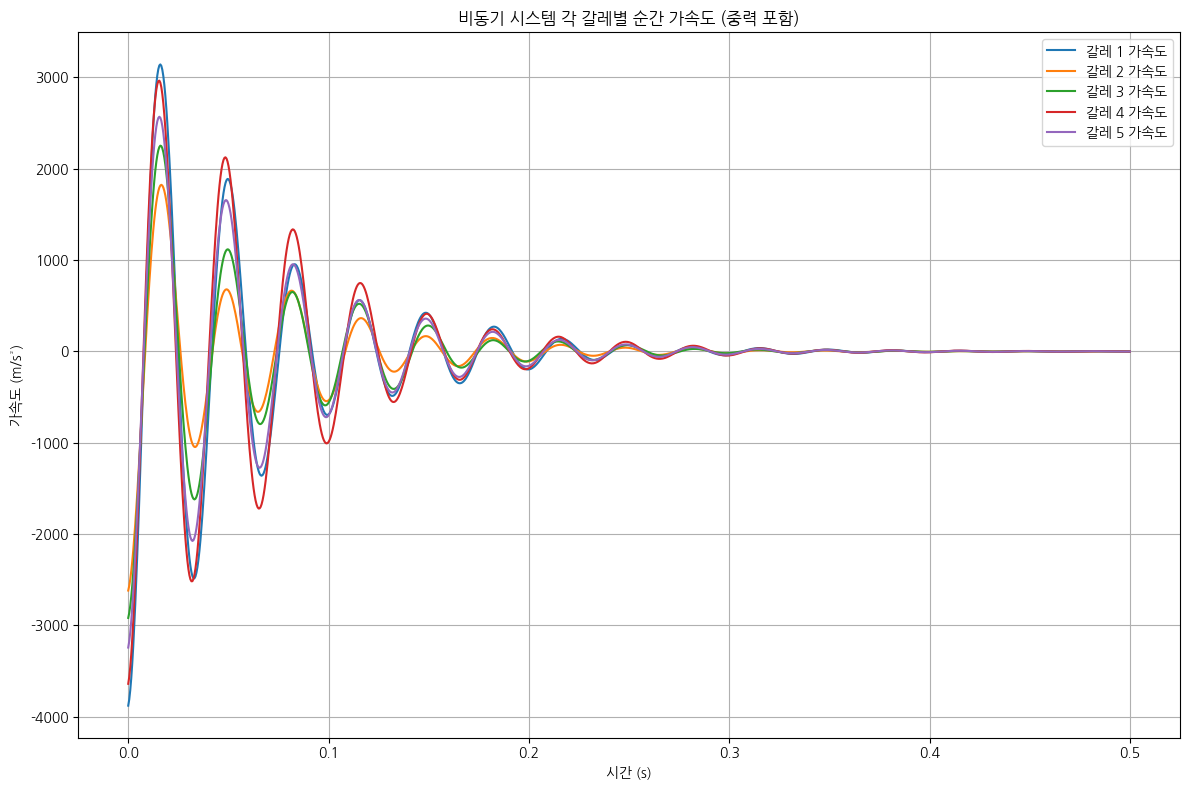

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 시스템 파라미터 ---
N = 5
k_base = 1000.0      # 스프링 상수
c_base = 1.0         # 감쇠 계수
m_base = 0.03        # 질량
K_int = 100.0        # 상호작용 스프링 상수

g = 9.81             # 중력가속도 (m/s^2)
x0 = 0.0             # 평형 위치 (고무줄이 늘어나지 않은 위치)

h0 = 0.1             # 초기 높이 (m) -> 이 위치에서 낙하 시작

# 시간 설정
t_span = (0, 0.5)
t_eval = np.linspace(*t_span, 1000)

# 상호작용 행렬 생성
K_matrix = np.full((N, N), -K_int)
np.fill_diagonal(K_matrix, 0)
for i in range(N):
    K_matrix[i, i] = -np.sum(K_matrix[i])

# --- 에너지 계산 함수 (중력 위치에너지 포함) ---
def compute_energy(x, v, k_i, m_i):
    # 위치에너지: 고무줄 위치에너지 + 중력 위치에너지
    U_spring = np.sum(0.5 * k_i[:, None] * (x - x0)**2, axis=0)
    U_gravity = np.sum(m_i[:, None] * g * x, axis=0)  # x가 위치 (높이)
    U = U_spring + U_gravity

    # 운동에너지
    K = np.sum(0.5 * m_i[:, None] * v**2, axis=0)
    return U, K, U + K

# --- 시스템 미분방정식 ---
def spring_damper_system(t, y, k_i, c_i, m_i):
    x = y[:N]
    v = y[N:]
    dxdt = v
    interaction = K_matrix @ x

    a = np.zeros(N)
    for i in range(N):
        # 중력 방향은 +x (아래 방향)
        # 스프링 및 상호작용 힘은 -k*(x-x0) + 상호작용
        # 중력가속도는 +g (중력 방향)
        force_spring = -k_i[i] * (x[i] - x0) + interaction[i]
        force_damping = -c_i[i] * v[i]
        force_gravity = m_i[i] * g

        total_force = force_spring + force_damping + force_gravity
        a[i] = total_force / m_i[i]
    return np.concatenate([dxdt, a])

# --- 동기 초기 조건 및 파라미터 ---
k_sync = np.full(N, k_base)
c_sync = np.full(N, c_base)
m_sync = np.full(N, m_base)

x_init_sync = np.full(N, h0)    # 초기 높이 h0에서 시작 (떨어지는 상태)
v_init_sync = np.zeros(N)
y0_sync = np.concatenate([x_init_sync, v_init_sync])

sol_sync = solve_ivp(spring_damper_system, t_span, y0_sync, t_eval=t_eval, args=(k_sync, c_sync, m_sync))
x_sync = sol_sync.y[:N]
v_sync = sol_sync.y[N:]

interaction_sync = K_matrix @ x_sync
a_sync = np.zeros_like(x_sync)
for i in range(len(t_eval)):
    for j in range(N):
        force_spring = -k_sync[j] * (x_sync[j, i] - x0) + interaction_sync[j, i]
        force_damping = -c_sync[j] * v_sync[j, i]
        force_gravity = m_sync[j] * g
        a_sync[j, i] = (force_spring + force_damping + force_gravity) / m_sync[j]

mean_accel_sync = np.mean(a_sync, axis=0)
U_sync, K_sync, E_sync = compute_energy(x_sync, v_sync, k_sync, m_sync)

# --- 비동기 초기 조건 및 파라미터 ---
np.random.seed(0)
k_async = k_base + 100 * np.random.randn(N)
c_async = c_base + 0.2 * np.random.randn(N)
m_async = m_base + 0.005 * np.random.randn(N)

x_init_async = h0 + 0.005 * np.random.randn(N)
v_init_async = np.zeros(N)

# 첫 갈레 초기 높이를 좀 더 높여 최고 가속도 유도
x_init_async[0] += 0.02

# --- 위치 에너지 정규화 (동기와 동일한 초기 에너지 총량) ---
U_target = np.sum(0.5 * k_sync * (x_init_sync - x0)**2 + m_sync * g * x_init_sync)
U_current = np.sum(0.5 * k_async * (x_init_async - x0)**2 + m_async * g * x_init_async)
scale = np.sqrt(U_target / U_current)
x_init_async = x0 + (x_init_async - x0) * scale

y0_async = np.concatenate([x_init_async, v_init_async])

sol_async = solve_ivp(spring_damper_system, t_span, y0_async, t_eval=t_eval, args=(k_async, c_async, m_async))
x_async = sol_async.y[:N]
v_async = sol_async.y[N:]

interaction_async = K_matrix @ x_async
a_async = np.zeros_like(x_async)
for i in range(len(t_eval)):
    for j in range(N):
        force_spring = -k_async[j] * (x_async[j, i] - x0) + interaction_async[j, i]
        force_damping = -c_async[j] * v_async[j, i]
        force_gravity = m_async[j] * g
        a_async[j, i] = (force_spring + force_damping + force_gravity) / m_async[j]

mean_accel_async = np.mean(a_async, axis=0)
U_async, K_async, E_async = compute_energy(x_async, v_async, k_async, m_async)

# --- 평균 절대값 가속도 및 최대 가속도 계산 ---
mean_abs_accel_sync = np.mean(np.abs(mean_accel_sync))
mean_abs_accel_async = np.mean(np.abs(mean_accel_async))
ratio_mean = mean_abs_accel_async / mean_abs_accel_sync

max_abs_accel_sync = np.max(np.abs(mean_accel_sync))
max_abs_accel_async = np.max(np.abs(mean_accel_async))
ratio_max = max_abs_accel_async / max_abs_accel_sync

print(f"동기 평균 |가속도|: {mean_abs_accel_sync:.4f}")
print(f"비동기 평균 |가속도|: {mean_abs_accel_async:.4f}")
print(f"비동기 / 동기 평균 비율: {ratio_mean:.4f}")
print()
print(f"동기 최대 |가속도|: {max_abs_accel_sync:.4f}")
print(f"비동기 최대 |가속도|: {max_abs_accel_async:.4f}")
print(f"비동기 / 동기 최대 비율: {ratio_max:.4f}")

# --- 그래프: 평균 절대값 순간 가속도 ---
plt.figure(figsize=(12, 6))
plt.plot(t_eval, np.abs(mean_accel_sync), label='동기 평균 |가속도|')
plt.plot(t_eval, np.abs(mean_accel_async), label='비동기 평균 |가속도|')
plt.title('시간에 따른 동기 / 비동기 평균 절대값 순간 가속도 (중력 포함)')
plt.xlabel('시간 (s)')
plt.ylabel('평균 절대값 가속도 (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 그래프: 비동기 각 갈레별 가속도 시간 추이 ---
plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, a_async[i], label=f'갈레 {i+1} 가속도')
plt.title('비동기 시스템 각 갈레별 순간 가속도 (중력 포함)')
plt.xlabel('시간 (s)')
plt.ylabel('가속도 (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


동기 평균 |가속도|: 254.9638
비동기 평균 |가속도|: 268.4246
비동기 / 동기 평균 비율: 1.0528

동기 최대 |가속도|: 3321.8567
비동기 최대 |가속도|: 3259.3906
비동기 / 동기 최대 비율: 0.9812

동기 마지막 평균 가속도: 0.7848 (기대값: 9.81)
비동기 마지막 평균 가속도: -1.5081 (기대값: 9.81)


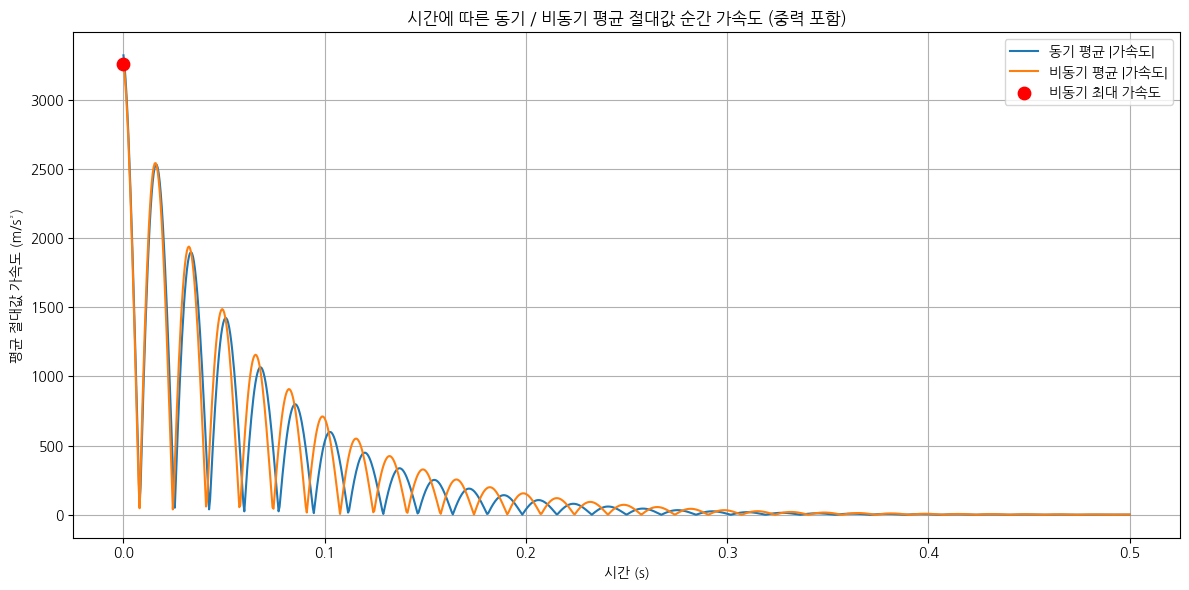

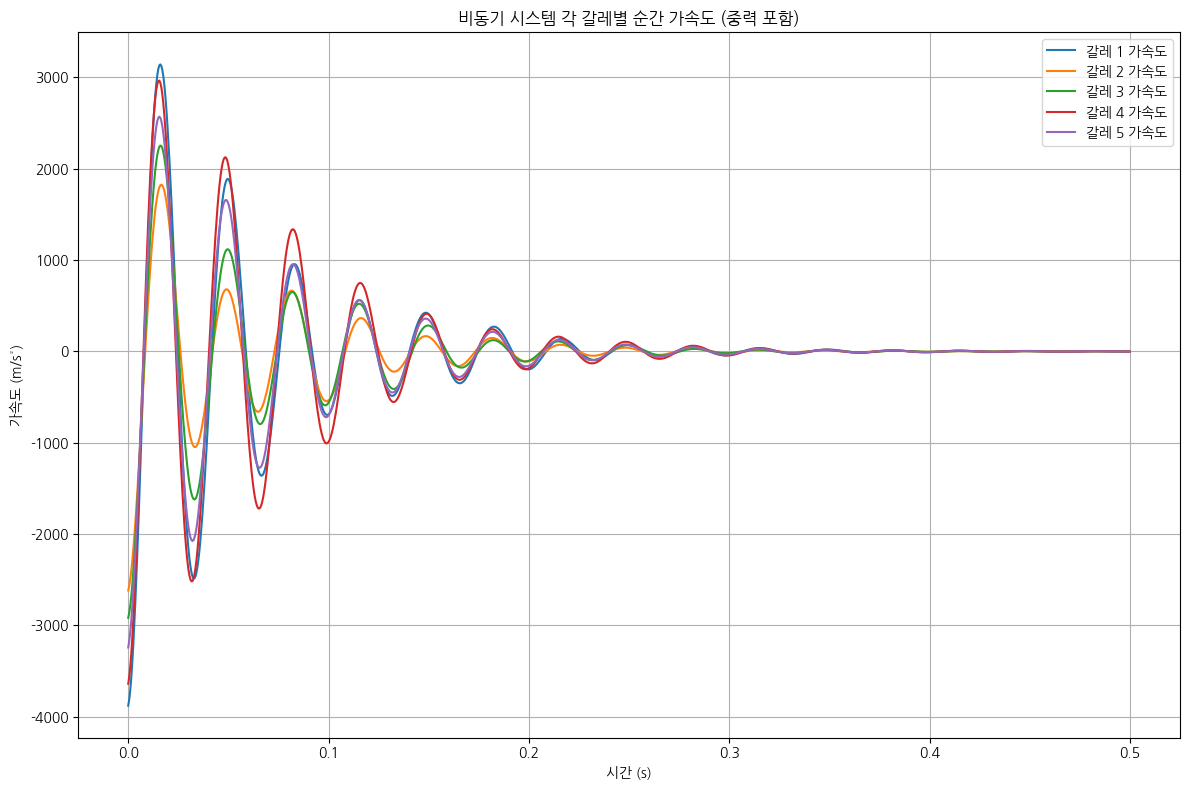

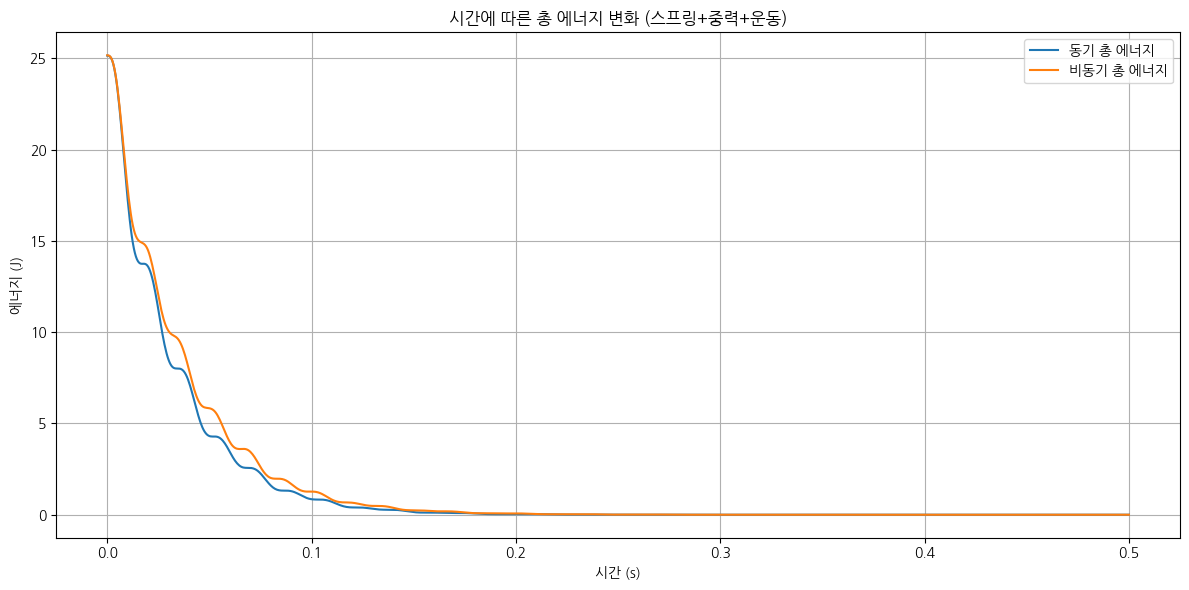

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 시스템 파라미터 ---
N = 5
k_base = 1000.0      # 스프링 상수
c_base = 1.0         # 감쇠 계수
m_base = 0.03        # 질량
K_int = 100.0        # 상호작용 스프링 상수

g = 9.81             # 중력가속도 (m/s^2)
x0 = 0.0             # 평형 위치 (고무줄 원래 길이)

h0 = 0.1             # 초기 높이 (m)

# 시간 설정
t_span = (0, 0.5)
t_eval = np.linspace(*t_span, 1000)

# 상호작용 행렬 생성
K_matrix = np.full((N, N), -K_int)
np.fill_diagonal(K_matrix, 0)
for i in range(N):
    K_matrix[i, i] = -np.sum(K_matrix[i])

# --- 에너지 계산 함수 ---
def compute_energy(x, v, k_i, m_i):
    U_spring = np.sum(0.5 * k_i[:, None] * (x - x0)**2, axis=0)
    U_gravity = np.sum(m_i[:, None] * g * x, axis=0)
    U = U_spring + U_gravity
    K = np.sum(0.5 * m_i[:, None] * v**2, axis=0)
    return U, K, U + K

# --- 시스템 미분방정식 ---
def spring_damper_system(t, y, k_i, c_i, m_i):
    x = y[:N]
    v = y[N:]
    dxdt = v
    interaction = K_matrix @ x

    a = np.zeros(N)
    for i in range(N):
        force_spring = -k_i[i] * (x[i] - x0) + interaction[i]
        force_damping = -c_i[i] * v[i]
        force_gravity = m_i[i] * g

        total_force = force_spring + force_damping + force_gravity
        a[i] = total_force / m_i[i]
    return np.concatenate([dxdt, a])

# --- 동기 초기 조건 ---
k_sync = np.full(N, k_base)
c_sync = np.full(N, c_base)
m_sync = np.full(N, m_base)

x_init_sync = np.full(N, h0)
v_init_sync = np.full(N, -0.05)
y0_sync = np.concatenate([x_init_sync, v_init_sync])

sol_sync = solve_ivp(spring_damper_system, t_span, y0_sync, t_eval=t_eval, args=(k_sync, c_sync, m_sync))
x_sync = sol_sync.y[:N]
v_sync = sol_sync.y[N:]

interaction_sync = K_matrix @ x_sync
a_sync = np.zeros_like(x_sync)
for i in range(len(t_eval)):
    for j in range(N):
        force_spring = -k_sync[j] * (x_sync[j, i] - x0) + interaction_sync[j, i]
        force_damping = -c_sync[j] * v_sync[j, i]
        force_gravity = m_sync[j] * g
        a_sync[j, i] = (force_spring + force_damping + force_gravity) / m_sync[j]

mean_accel_sync = np.mean(a_sync, axis=0)
U_sync, K_sync, E_sync = compute_energy(x_sync, v_sync, k_sync, m_sync)

# --- 비동기 초기 조건 ---
np.random.seed(0)
k_async = k_base + 100 * np.random.randn(N)
c_async = c_base + 0.2 * np.random.randn(N)
m_async = m_base + 0.005 * np.random.randn(N)

x_init_async = h0 + 0.005 * np.random.randn(N)
v_init_async = np.full(N, -0.05)

x_init_async[0] += 0.02

U_target = np.sum(0.5 * k_sync * (x_init_sync - x0)**2 + m_sync * g * x_init_sync)
U_current = np.sum(0.5 * k_async * (x_init_async - x0)**2 + m_async * g * x_init_async)
scale = np.sqrt(U_target / U_current)
x_init_async = x0 + (x_init_async - x0) * scale

y0_async = np.concatenate([x_init_async, v_init_async])

sol_async = solve_ivp(spring_damper_system, t_span, y0_async, t_eval=t_eval, args=(k_async, c_async, m_async))
x_async = sol_async.y[:N]
v_async = sol_async.y[N:]

interaction_async = K_matrix @ x_async
a_async = np.zeros_like(x_async)
for i in range(len(t_eval)):
    for j in range(N):
        force_spring = -k_async[j] * (x_async[j, i] - x0) + interaction_async[j, i]
        force_damping = -c_async[j] * v_async[j, i]
        force_gravity = m_async[j] * g
        a_async[j, i] = (force_spring + force_damping + force_gravity) / m_async[j]

mean_accel_async = np.mean(a_async, axis=0)
U_async, K_async, E_async = compute_energy(x_async, v_async, k_async, m_async)

# --- 평균 절대값 가속도 및 최대 가속도 계산 ---
mean_abs_accel_sync = np.mean(np.abs(mean_accel_sync))
mean_abs_accel_async = np.mean(np.abs(mean_accel_async))
ratio_mean = mean_abs_accel_async / mean_abs_accel_sync

max_abs_accel_sync = np.max(np.abs(mean_accel_sync))
max_abs_accel_async = np.max(np.abs(mean_accel_async))
ratio_max = max_abs_accel_async / max_abs_accel_sync

last_mean_accel_sync = mean_accel_sync[-1]
last_mean_accel_async = mean_accel_async[-1]

print(f"동기 평균 |가속도|: {mean_abs_accel_sync:.4f}")
print(f"비동기 평균 |가속도|: {mean_abs_accel_async:.4f}")
print(f"비동기 / 동기 평균 비율: {ratio_mean:.4f}")
print()
print(f"동기 최대 |가속도|: {max_abs_accel_sync:.4f}")
print(f"비동기 최대 |가속도|: {max_abs_accel_async:.4f}")
print(f"비동기 / 동기 최대 비율: {ratio_max:.4f}")
print()
print(f"동기 마지막 평균 가속도: {last_mean_accel_sync:.4f} (기대값: {g})")
print(f"비동기 마지막 평균 가속도: {last_mean_accel_async:.4f} (기대값: {g})")

# --- 그래프: 평균 절대값 순간 가속도 ---
plt.figure(figsize=(12, 6))
plt.plot(t_eval, np.abs(mean_accel_sync), label='동기 평균 |가속도|')
plt.plot(t_eval, np.abs(mean_accel_async), label='비동기 평균 |가속도|')

# 비동기 최대 가속도 위치 표시
max_idx = np.argmax(np.abs(mean_accel_async))
plt.scatter(t_eval[max_idx], np.abs(mean_accel_async)[max_idx], color='red', s=80, label='비동기 최대 가속도', zorder=5)

plt.title('시간에 따른 동기 / 비동기 평균 절대값 순간 가속도 (중력 포함)')
plt.xlabel('시간 (s)')
plt.ylabel('평균 절대값 가속도 (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 그래프: 비동기 각 갈레별 가속도 시간 추이 ---
plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, a_async[i], label=f'갈레 {i+1} 가속도')
plt.title('비동기 시스템 각 갈레별 순간 가속도 (중력 포함)')
plt.xlabel('시간 (s)')
plt.ylabel('가속도 (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 그래프: 전체 에너지 변화 ---
plt.figure(figsize=(12, 6))
plt.plot(t_eval, E_sync, label='동기 총 에너지')
plt.plot(t_eval, E_async, label='비동기 총 에너지')

plt.title('시간에 따른 총 에너지 변화 (스프링+중력+운동)')
plt.xlabel('시간 (s)')
plt.ylabel('에너지 (J)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


동기 평균 |가속도|: 77.6447
비동기 평균 |가속도|: 8193161906.8083
비동기 / 동기 평균 비율: 105521207.4454

동기 최대 |가속도| 합산: 5049.0000
비동기 최대 |가속도| 합산: 68964752604948.8906
비동기 / 동기 최대 비율: 13659091425.0245


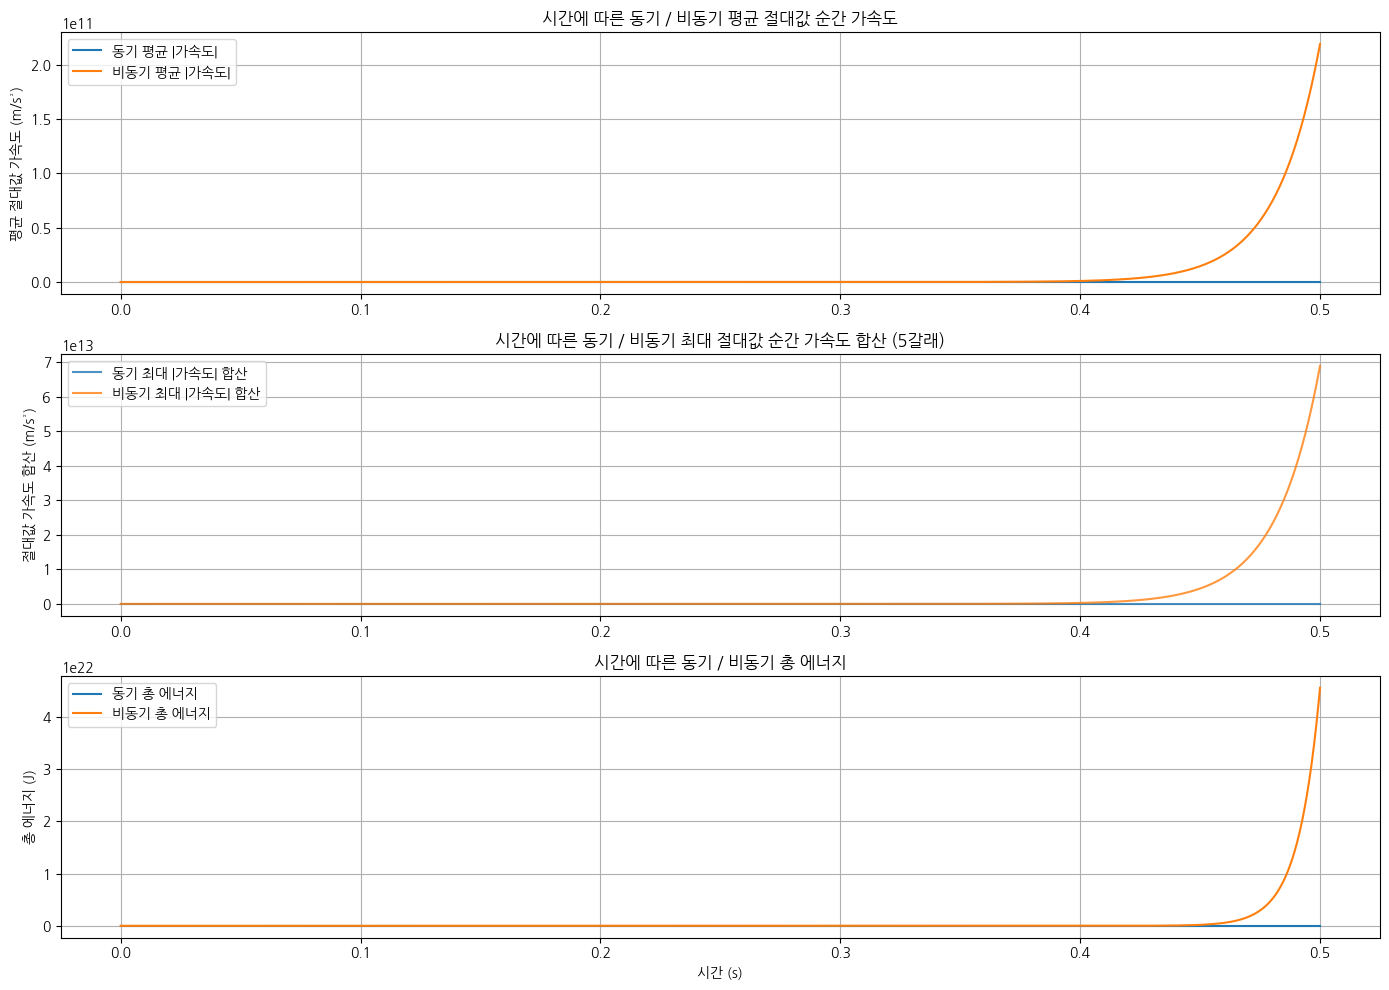

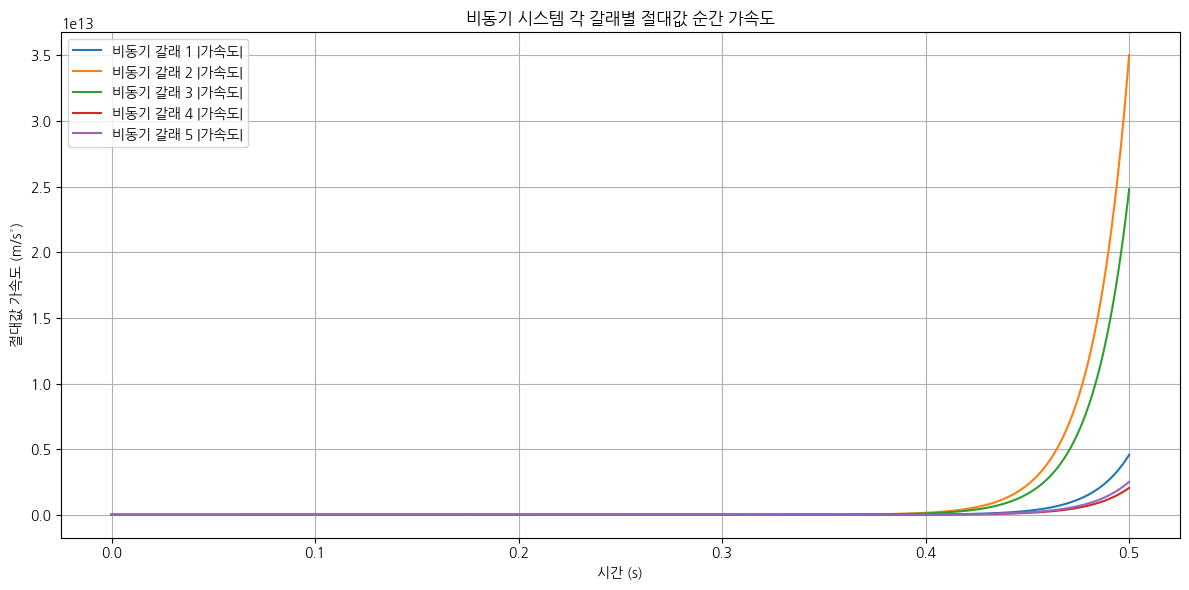

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 시스템 파라미터 ---
N = 5
k_base = 300.0            # 기본 스프링 상수 낮춤 (1000 -> 300) 가속도 절대값 축소 목적
c_base = 1.0
m_base = 0.03
K_int = 100.0
x0 = 0.0
g = 9.8
h0 = 0.1

t_span = (0, 0.5)
t_eval = np.linspace(*t_span, 1000)

K_matrix = np.full((N, N), -K_int)
np.fill_diagonal(K_matrix, 0)
for i in range(N):
    K_matrix[i, i] = -np.sum(K_matrix[i])

def compute_energy(x, v, k_i, m_i):
    U_spring = np.sum(0.5 * k_i[:, None] * (x - x0)**2, axis=0)
    U_gravity = np.sum(m_i[:, None] * g * x, axis=0)
    K = np.sum(0.5 * m_i[:, None] * v**2, axis=0)
    return U_spring, U_gravity, K, U_spring + U_gravity + K

def spring_damper_system(t, y, k_i, c_i, m_i):
    x = y[:N]
    v = y[N:]
    dxdt = v
    interaction = K_matrix @ x
    a = np.zeros(N)
    for i in range(N):
        a[i] = (-k_i[i] * (x[i] - x0) - c_i[i] * v[i] + interaction[i] - m_i[i]*g) / m_i[i]
    return np.concatenate([dxdt, a])

# --- 동기 ---
k_sync = np.full(N, k_base)
c_sync = np.full(N, c_base)
m_sync = np.full(N, m_base)
x_init_sync = np.full(N, h0)
v_init_sync = np.zeros(N)
y0_sync = np.concatenate([x_init_sync, v_init_sync])

sol_sync = solve_ivp(spring_damper_system, t_span, y0_sync, t_eval=t_eval, args=(k_sync, c_sync, m_sync))
x_sync = sol_sync.y[:N]
v_sync = sol_sync.y[N:]

interaction_sync = K_matrix @ x_sync
a_sync = np.zeros_like(x_sync)
for i in range(len(t_eval)):
    for j in range(N):
        a_sync[j, i] = (-k_sync[j]*(x_sync[j,i]-x0) - c_sync[j]*v_sync[j,i] + interaction_sync[j,i] - m_sync[j]*g) / m_sync[j]

U_spring_sync, U_gravity_sync, K_sync, E_sync = compute_energy(x_sync, v_sync, k_sync, m_sync)

# --- 비동기 ---
np.random.seed(0)
# 분산 줄이고 비동기성 유지
k_async = k_base + 50 * np.random.randn(N)   # 변동폭 축소 (150 -> 50)
c_async = c_base + 0.2 * np.random.randn(N)  # 감쇠 변동 축소
m_async = m_base + 0.005 * np.random.randn(N)

x_init_async = h0 + 0.02 * np.random.randn(N)  # 위치 변동 약간 증가 (0.01 -> 0.02)
x_init_async[0] += 0.04  # 한 갈래만 더 크게 초기 위치 띄워서 가속도 증대

v_init_async = np.full(N, -0.07)  # 초기 낙하 속도 약간 증가

# 에너지 맞춤
U_target = np.sum(0.5*k_sync*(x_init_sync-x0)**2 + m_sync*g*x_init_sync)
U_current = np.sum(0.5*k_async*(x_init_async-x0)**2 + m_async*g*x_init_async)
scale = np.sqrt(U_target / U_current)
x_init_async = x0 + (x_init_async - x0)*scale

y0_async = np.concatenate([x_init_async, v_init_async])

sol_async = solve_ivp(spring_damper_system, t_span, y0_async, t_eval=t_eval, args=(k_async, c_async, m_async))
x_async = sol_async.y[:N]
v_async = sol_async.y[N:]

interaction_async = K_matrix @ x_async
a_async = np.zeros_like(x_async)
for i in range(len(t_eval)):
    for j in range(N):
        a_async[j, i] = (-k_async[j]*(x_async[j,i]-x0) - c_async[j]*v_async[j,i] + interaction_async[j,i] - m_async[j]*g) / m_async[j]

U_spring_async, U_gravity_async, K_async, E_async = compute_energy(x_async, v_async, k_async, m_async)

mean_abs_accel_sync = np.mean(np.abs(np.mean(a_sync, axis=0)))
mean_abs_accel_async = np.mean(np.abs(np.mean(a_async, axis=0)))
ratio_avg = mean_abs_accel_async / mean_abs_accel_sync

sum_abs_accel_sync = np.sum(np.abs(a_sync), axis=0)
sum_abs_accel_async = np.sum(np.abs(a_async), axis=0)
max_sum_abs_accel_sync = np.max(sum_abs_accel_sync)
max_sum_abs_accel_async = np.max(sum_abs_accel_async)
ratio_max = max_sum_abs_accel_async / max_sum_abs_accel_sync

print(f"동기 평균 |가속도|: {mean_abs_accel_sync:.4f}")
print(f"비동기 평균 |가속도|: {mean_abs_accel_async:.4f}")
print(f"비동기 / 동기 평균 비율: {ratio_avg:.4f}\n")

print(f"동기 최대 |가속도| 합산: {max_sum_abs_accel_sync:.4f}")
print(f"비동기 최대 |가속도| 합산: {max_sum_abs_accel_async:.4f}")
print(f"비동기 / 동기 최대 비율: {ratio_max:.4f}")

plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(t_eval, np.abs(np.mean(a_sync, axis=0)), label='동기 평균 |가속도|')
plt.plot(t_eval, np.abs(np.mean(a_async, axis=0)), label='비동기 평균 |가속도|')
plt.title('시간에 따른 동기 / 비동기 평균 절대값 순간 가속도')
plt.ylabel('평균 절대값 가속도 (m/s²)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_eval, sum_abs_accel_sync, label='동기 최대 |가속도| 합산', alpha=0.8)
plt.plot(t_eval, sum_abs_accel_async, label='비동기 최대 |가속도| 합산', alpha=0.8)
plt.title('시간에 따른 동기 / 비동기 최대 절대값 순간 가속도 합산 (5갈래)')
plt.ylabel('절대값 가속도 합산 (m/s²)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t_eval, E_sync, label='동기 총 에너지')
plt.plot(t_eval, E_async, label='비동기 총 에너지')
plt.title('시간에 따른 동기 / 비동기 총 에너지')
plt.xlabel('시간 (s)')
plt.ylabel('총 에너지 (J)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(t_eval, np.abs(a_async[i]), label=f'비동기 갈래 {i+1} |가속도|')
plt.title('비동기 시스템 각 갈래별 절대값 순간 가속도')
plt.xlabel('시간 (s)')
plt.ylabel('절대값 가속도 (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
